In [2]:
#import libraries
import csv as csv
import numpy as np
import pandas as pd
import math
from sklearn import svm
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from time import time

In [3]:
#importing training and testing data and combining training and testing data for feature extraction
train = pd.read_csv('train.csv',header=0)
test = pd.read_csv('test.csv',header = 0)
train.drop(['casual','registered'],axis=1, inplace=True)
targets = train['count']
combined = train.drop('count',axis=1).append(test)
combined.reset_index(inplace = True, drop =True)

In [4]:
#features before any feature extraction
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 9 columns):
datetime      17379 non-null object
season        17379 non-null int64
holiday       17379 non-null int64
workingday    17379 non-null int64
weather       17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
humidity      17379 non-null int64
windspeed     17379 non-null float64
dtypes: float64(3), int64(5), object(1)
memory usage: 1.2+ MB


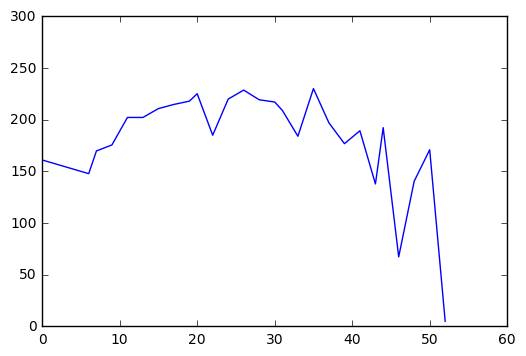

30

In [5]:
#Visualisations
#Plotting mean count vs windspeed
categories_windspeed = combined.windspeed.unique()
categories_windspeed = np.sort(categories_windspeed)
MeanCountwindspeed = []
train = combined.loc[0:10885,:]
train = pd.concat([targets,train],axis=1)
for i in categories_windspeed:
    MeanCountwindspeed.append(train.loc[train['windspeed'] == i,'count'].mean())
plt.plot(categories_windspeed, MeanCountwindspeed)
plt.show()
categories_windspeed.size

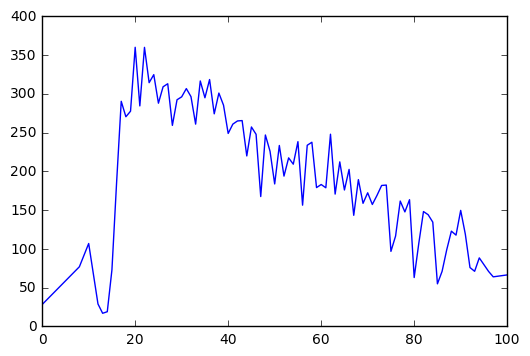

89

In [6]:
#Plotting mean count vs humidity
categories_humidity = combined.humidity.unique()
categories_humidity = np.sort(categories_humidity)
MeanCountHumidity = []
train = combined.loc[0:10885,:]
train = pd.concat([targets,train],axis=1)
for i in categories_humidity:
    MeanCountHumidity.append(train.loc[train['humidity'] == i,'count'].mean())
plt.plot(categories_humidity, MeanCountHumidity)
plt.show()
categories_humidity.size

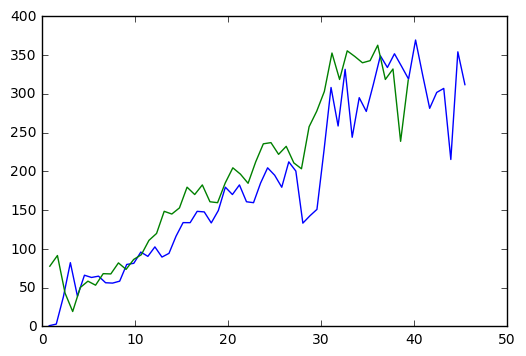

In [7]:
#Plotting mean count vs temp and atemp
categories_atemp = combined.atemp.unique()
categories_atemp = np.sort(categories_atemp)
MeanCountAtemp = []
train = combined.loc[0:10885,:]
train = pd.concat([targets,train],axis=1)
for i in categories_atemp:
    MeanCountAtemp.append(train.loc[train['atemp'] == i,'count'].mean())
plt.plot(categories_atemp, MeanCountAtemp)

categories_temp = combined.temp.unique()
categories_temp = np.sort(categories_temp)
MeanCounttemp=[]
train = combined.loc[0:10885,:]
train = pd.concat([targets,train],axis=1)
for i in categories_temp:
    MeanCounttemp.append(train.loc[train['temp'] == i,'count'].mean())
plt.plot(categories_temp, MeanCounttemp)

plt.show()

In [8]:
# Creating Hour (nominal categorical feature) and converting it into grouped boolean feature
combined['hour'] = combined.datetime.map(lambda date: date.split(':')[0].split(' ')[1])
combined['hour'] = combined['hour'].astype(int)
combined = combined.drop(['datetime'], axis =1)

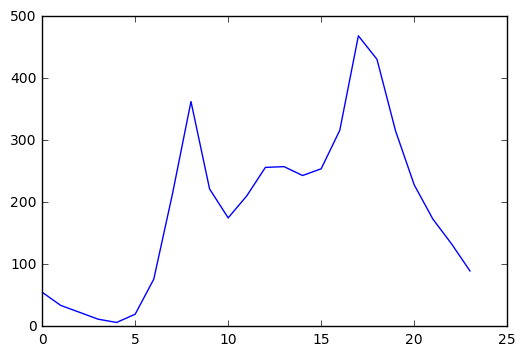

In [9]:
#plotting mean count of bikes in 24hour cycle
MeanCountHourly = []
train = combined.loc[0:10885,:]
train = pd.concat([targets,train],axis=1)
for i in range(0,24):
    MeanCountHourly.append(train.loc[train['hour'] == i,'count'].mean())
plt.plot(range(0,24),MeanCountHourly)
plt.show()

In [10]:
#Extracting more features
#creating dummy variables from hour
combined['is_earlyMorning'] = ((combined['hour']>=0) &(combined['hour']<=6)).astype(int)
combined['is_morning'] = ((combined['hour']>6)&(combined['hour']<=10)).astype(int)
combined['is_day'] = ((combined['hour']>10)&(combined['hour']<=15)).astype(int)
combined['is_evening'] = ((combined['hour']>15)&(combined['hour']<=20)).astype(int)
combined['is_night'] = ((combined['hour']>20)&(combined['hour']<=23)).astype(int)

#Creating Season dummy features
class_season = pd.get_dummies(combined.season, prefix='Season')
combined = pd.concat([combined, class_season],axis=1)
combined.drop(['season'],axis=1,inplace=True)

#Creating Weather Dummy features
class_weather = pd.get_dummies(combined.weather, prefix = 'Weather')
combined = pd.concat([combined, class_weather], axis=1)
combined.drop(['weather'], axis=1, inplace=True)

#Creating Humidity group boolean features
combined['is_VeryLowHumidity'] = ((combined['humidity']>=0)&(combined['humidity']<=19)).astype(int)
combined['is_LowHumidity'] = ((combined['humidity']>=20)&(combined['humidity']<=40)).astype(int)
combined['is_MediumHumidity'] = ((combined['humidity']>40)&(combined['humidity']<=60)).astype(int)
combined['is_HighHumidity'] = ((combined['humidity']>60)&(combined['humidity']<=75)).astype(int)
combined['is_VeryHumidity'] = (combined['humidity']>75).astype(int)


#Creating Windspeed group boolean features
combined['is_LowWindSpeed'] = ((combined['windspeed']>=0)&(combined['windspeed']<=10)).astype(int)
combined['is_MediumWindSpeed'] = ((combined['windspeed']>10)&(combined['windspeed']<=42)).astype(int)
combined['is_HighWindSpeed'] = (combined['windspeed']>42).astype(int)

#Weekend would be when  both working day and holiday are false
combined['is_weekend'] = ((combined['holiday']==0) &(combined['workingday']==0)).astype(int)

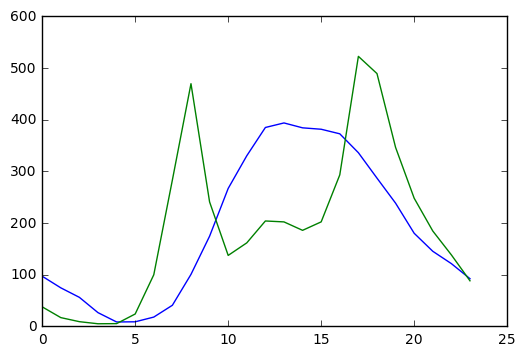

In [11]:
#Plot of weekend hourly vs weekday hourly mean count
MeanCountHourlyWeekend = []
MeanCountHourlyWeekDay =[]
train = combined.loc[0:10885,:]
train = pd.concat([targets,train],axis=1)
for i in range(0,24):
    MeanCountHourlyWeekend.append(train.loc[(train['hour'] == i)&(train['is_weekend']==1),'count'].mean())
    MeanCountHourlyWeekDay.append(train.loc[(train['hour'] == i)&(train['is_weekend']==0),'count'].mean())
plt.plot(range(0,24),MeanCountHourlyWeekend)
plt.plot(range(0,24),MeanCountHourlyWeekDay)
plt.show()
#We can see that during the weekend, there's considerable difference in hourly pattern of mean count, whereas during
#weekdays pattern is similar to the mean of all the days

In [12]:
#Drop Low importance features
combined.drop(['Weather_4','is_HighWindSpeed','is_VeryLowHumidity','is_LowHumidity','is_HighHumidity','is_MediumHumidity','Weather_2','is_MediumWindSpeed','is_LowWindSpeed'],axis=1, inplace=True)

In [13]:
#Recombining
train = combined.loc[0:10885,:]
test = combined.loc[10886:17378,:]

In [14]:
#Creating a scoring function as defined in the problem
#X, y are numpy arrays

def scorer(y,pred):
    sub = np.sum(np.square(np.log(pred+1)-np.log(y+1)))
    return np.sqrt((1/y.size)*sub)
rmsle = make_scorer(scorer, greater_is_better = True)

In [15]:
#Creating output dataframe, scaling features and defining classifier
FeatureImp = pd.DataFrame()
FeatureImp['Feature'] = train.columns

train = preprocessing.scale(train)
test = preprocessing.scale(test)

clf  = RandomForestRegressor()

In [125]:
# Grid Search 
parameter_grid = {
                 'n_estimators' : [200, 210, 230, 240],
                 'max_depth': [4,5,6,7,9,10]
                 }
grid_search = GridSearchCV(clf, param_grid=parameter_grid, scoring = rmsle, cv=5)
grid_search.fit(train, targets)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: -0.5667413725147924
Best parameters: {'n_estimators': 210, 'max_depth': 10}


In [16]:
## Training Accuracy
clf  = RandomForestRegressor(n_estimators = 800, max_depth =10)
clf.fit(train, targets)
print ('Training Error: ', scorer(targets, clf.predict(train)))

Training Error:  0.352839596606


In [17]:
## Feature Importances
FeatureImp['Importance'] = clf.feature_importances_
FeatureImp.sort(['Importance'],ascending = False)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,Feature,Importance
6,hour,0.351383
7,is_earlyMorning,0.190731
2,temp,0.098874
10,is_evening,0.090670
1,workingday,0.060262
3,atemp,0.038242
4,humidity,0.036620
19,is_weekend,0.026107
12,Season_1,0.025660
9,is_day,0.021217


In [18]:
#Cross validation score
print (np.mean(cross_val_score(clf, train, targets, cv = 5, scoring=rmsle)))

0.567834199581


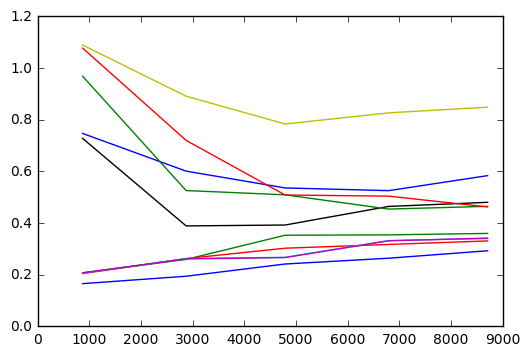

In [22]:
#Plot learning curve
train_sizes_abs, train_scores, test_scores = learning_curve(clf,train, targets, cv=5, scoring=rmsle,train_sizes=np.array([ 0.1, 0.33, 0.55, 0.78, 1. ]))
plt.plot(train_sizes_abs, train_scores)
plt.plot(train_sizes_abs, test_scores)
plt.show()

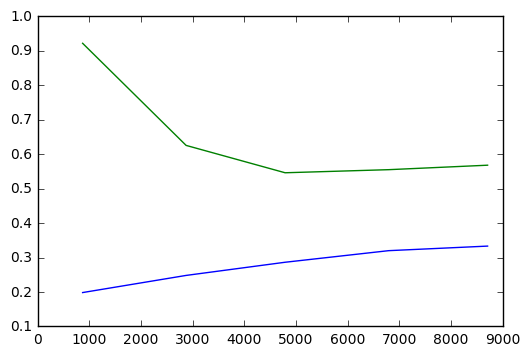

In [23]:
#Mean learning curves for different cross validation folds
train_score_mean = np.mean(train_scores,axis=1)
test_score_mean = np.mean(test_scores,axis=1)
plt.plot(train_sizes_abs,train_score_mean)
plt.plot(train_sizes_abs, test_score_mean)
plt.show()
#its still a high variance problem

In [19]:
#Current Position: Rank 1318, Error: 0.48415
pred = clf.predict(test)
pred[pred<0] = 0
dfPred = pd.DataFrame()
test1 = pd.read_csv('test.csv',header = 0)
dfPred['datetime'] = test1.datetime
dfPred['count'] = pd.DataFrame(pred)
dfPred.to_csv('mySubmissionBSD.csv', index=False)

In [51]:
dfPred.as_matrix()

array([['2011-01-20 00:00:00', 13.423921882878258],
       ['2011-01-20 01:00:00', 5.581078326543319],
       ['2011-01-20 02:00:00', 4.3664494514881165],
       ..., 
       ['2012-12-31 21:00:00', 74.8940125275623],
       ['2012-12-31 22:00:00', 77.71399800084967],
       ['2012-12-31 23:00:00', 44.82536305989254]], dtype=object)